# **This is the beginning of the Project Work!**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

#Set seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Parameters
d = 200          # Input dimension
k = 4           # Hidden units
a=2
n = a * k*d       # Increase number of samples for better train/test split
test_ratio = 0.2

# Generate teacher weights and data
W_teacher = np.random.randn(d, k)
X = np.random.randn(n, d)

# Modified teacher network with tanh activation
hidden_outputs = np.tanh(X @ W_teacher)  # Changed from sign to tanh
Y = np.sign(np.sum(hidden_outputs, axis=1))  # Keep binary labels

# Convert labels to {0,1} for BCE loss/ Binary cross entropy
Y_bin = ((Y + 1) // 2).reshape(-1, 1)

# Train/test split with shuffling
indices = np.random.permutation(n)
split = int(n * (1 - test_ratio))
X_train, X_test = X[indices[:split]], X[indices[split:]]
Y_train, Y_test = Y_bin[indices[:split]], Y_bin[indices[split:]]

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Student with similar architecture
class StudentNet(nn.Module):                       # Defines a new neural network class called StudentNet, which inherits from nn.Module, the base class for all neural networks in PyTorch
    def __init__(self, d, k):                      # Constructor method to initializes the neural network's architecture.
        super(StudentNet, self).__init__()         # constructor of the parent class nn.Module, allowing the model to inherit all PyTorch functionality like .parameters() and .to(device)
        self.fc1 = nn.Linear(d, k)                 # This creates the first fully connected (linear) layer, which takes an input of size d and outputs a vector of size k
        self.act = nn.Tanh()                       # Sets the activation function for the hidden layer to tanh, which squashes the output between -1 and 1
        self.fc2 = nn.Linear(k, 1)                 # Defines the second linear layer, taking input of size k from the hidden layer and producing a single output (for binary classification)

    def forward(self, x):                          # Define how data flows through the network.
        x = self.act(self.fc1(x))                  # Apply the first linear layer to our input and the apply the tanh activation function.
        return torch.sigmoid(self.fc2(x))

model = StudentNet(d, k)
loss_fn = nn.BCELoss()                                        # Distance between predicted probabilities and the true labels
optimizer = optim.SGD(model.parameters(), lr=0.1)             # passes all the learnable weights, lr= learning rate

# Training loop with test evaluation
epochs = 100
checkpoints = []                                             # Store snapshots of the model's weights at certain epochs.
train_loss_history = []                                      # We store the training loss and accuracy.
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(epochs):
    # Training phase
    model.train()                                      # Sets the model to training mode, so that such layers function correctly.
    optimizer.zero_grad()                              # Clear the gradients from the previous iteration.
    outputs = model(X_train_tensor)
    loss = loss_fn(outputs, Y_train_tensor)
    loss.backward()
    optimizer.step()                                  # Update the model parameters using the gradients calculated during backpropagation

    with torch.no_grad():                             # Disables gradient tracking to speed up computation.
        # Track metrics
        train_preds = (outputs > 0.5).float()                                  # Convert  probabilities to binary class predictions (0 or 1)
        train_acc = (train_preds == Y_train_tensor).float().mean().item()      # Compares the predicted labels to the true training labels
        test_outputs = model(X_test_tensor)
        test_loss = loss_fn(test_outputs, Y_test_tensor).item()                # .item() extracts the scalar value from the loss tensor
        test_preds = (test_outputs > 0.5).float()
        test_acc = ((test_outputs > 0.5).float() == Y_test_tensor).float().mean().item()

        # Track every 10 epochs
        if epoch % 10 == 0:
              torch.save(model.state_dict(), f"checkpoint_epoch_{epoch}.pt")
             #H = model.act(model.fc1(X_train_tensor)).numpy()                   # We obtain the activated neuron representation of training data.    # .numpy() converts the tensor to a NumPy array
              checkpoints.append(epoch)

    # Store history
    train_loss_history.append(loss.item())
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)

# Final metrics
print(f"Final Training Accuracy: {train_acc_history[-1] * 100:.2f}%")
print(f"Final Test Accuracy: {test_acc_history[-1] * 100:.2f}%")

Final Training Accuracy: 92.50%
Final Test Accuracy: 81.56%


In [ ]:
# Store weight overlaps every 10 epochs
Wi_logs = []  # To store student weights at intervals
Si_logs = []  # To store overlap matrices
epochs_to_log = []

for epoch in checkpoints:
    # Re-run model up to this epoch to get fc1 weights
    model_at_epoch = StudentNet(d, k)
    model_at_epoch.load_state_dict(torch.load(f"checkpoint_epoch_{epoch}.pt"))
    Wi = model_at_epoch.fc1.weight.detach().numpy().T  # shape: (d, k)
    Si = (W_teacher.T @ Wi) / d                        # shape: (k, k)

    Wi_logs.append(Wi)
    Si_logs.append(Si ** 2)
    epochs_to_log.append(epoch)


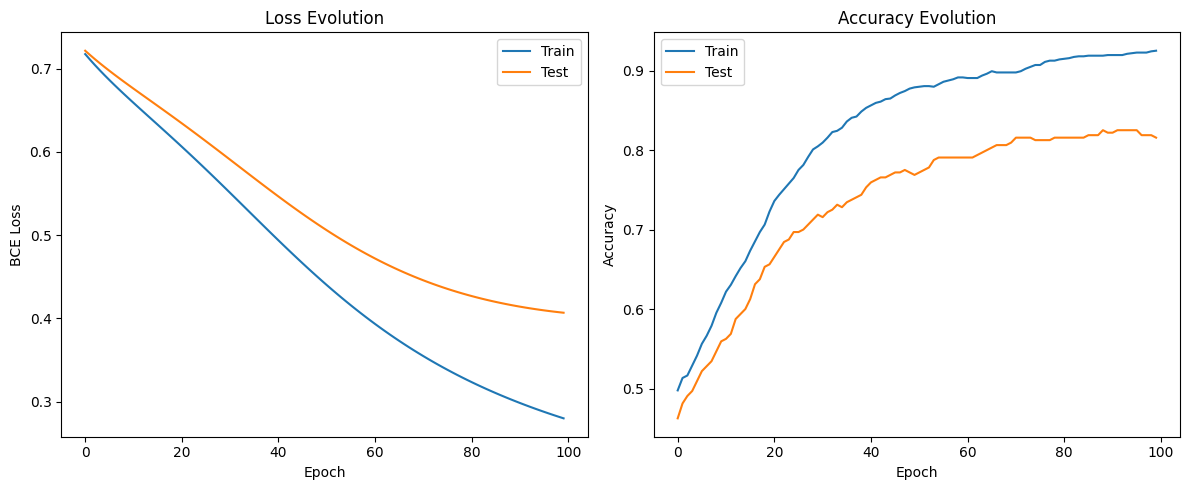

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(test_loss_history, label='Test')
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train')
plt.plot(test_acc_history, label='Test')
plt.title('Accuracy Evolution')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


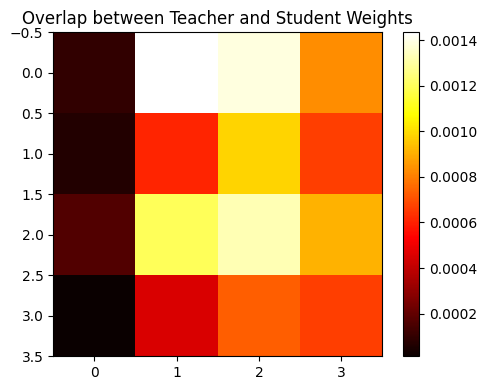

In [ ]:
W_student = model.fc1.weight.detach().numpy().T  # Shape (d, k) #Extracts the learned weights of the student model’s first layer and transposes
S = (W_teacher.T @ W_student) / d                # Shape (k, k), normalized dot product

# Plot squared overlap matrix
fig, ax = plt.subplots(figsize=(5, 4))
cax = ax.imshow(S**2, cmap='hot', aspect='auto')  # Element-wise square
fig.colorbar(cax)
ax.set_title('Overlap between Teacher and Student Weights')
plt.tight_layout()
plt.show()

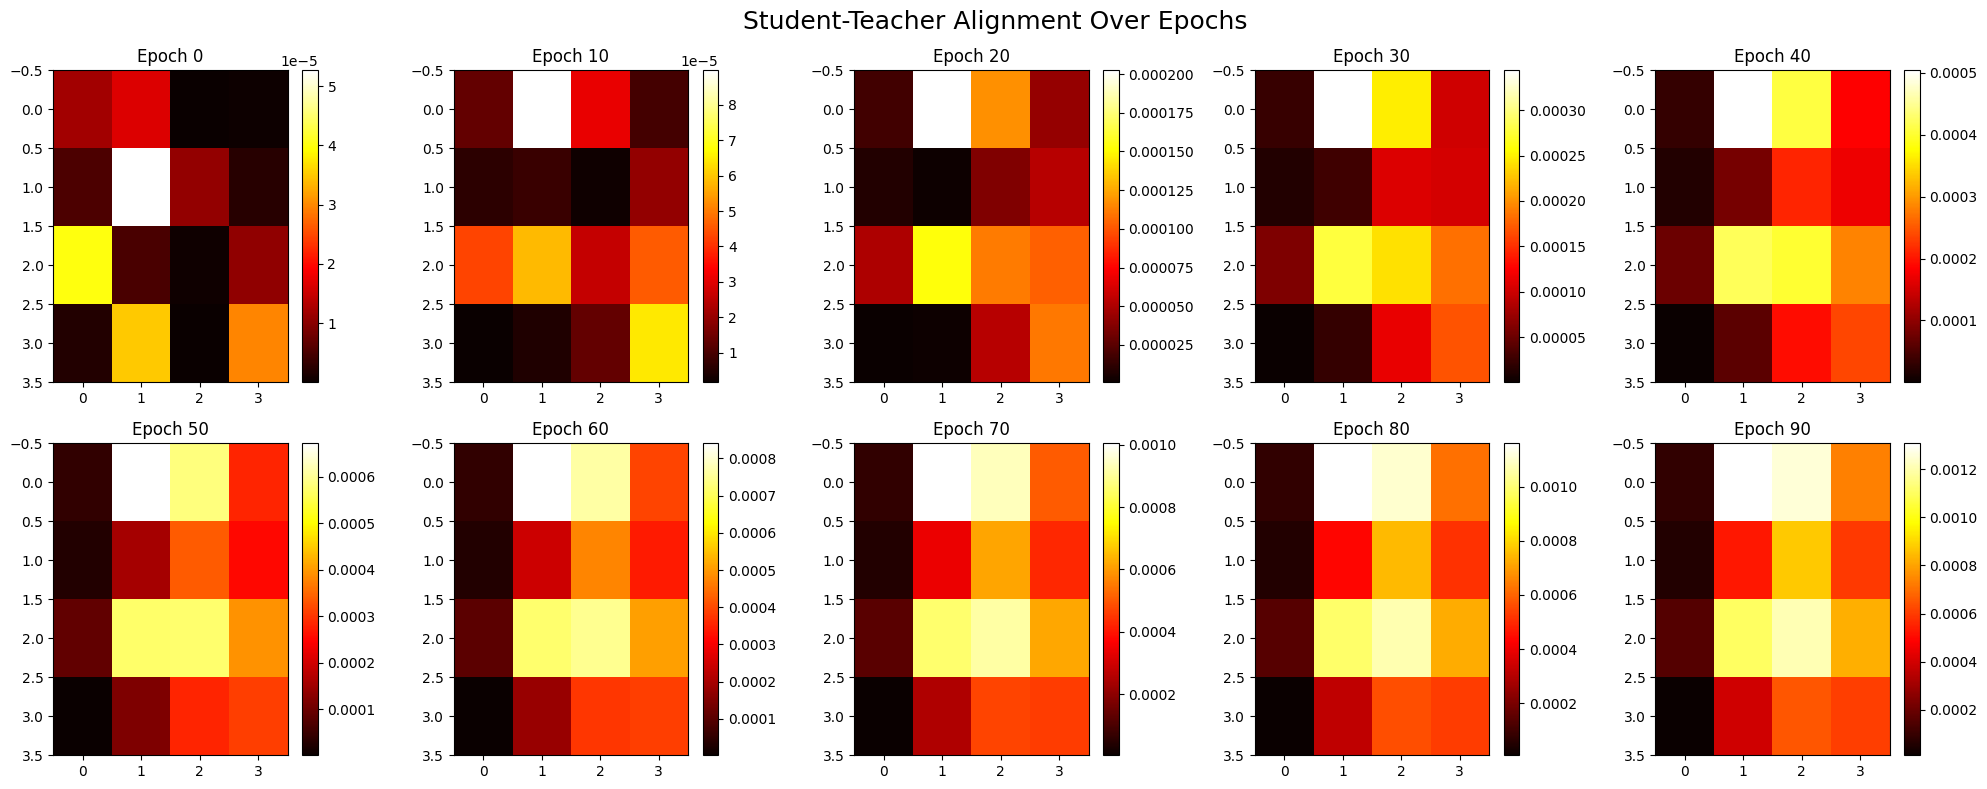

In [ ]:
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), tight_layout=True)

# Flatten axes for easier iteration
axes = axes.flatten()

for i, (Si, epoch) in enumerate(zip(Si_logs, epochs_to_log)):
    im = axes[i].imshow(Si, cmap='hot', aspect='auto')
    axes[i].set_title(f"Epoch {epoch}")
    fig.colorbar(im, ax=axes[i])

plt.suptitle("Student-Teacher Alignment Over Epochs", fontsize=18)
plt.show()


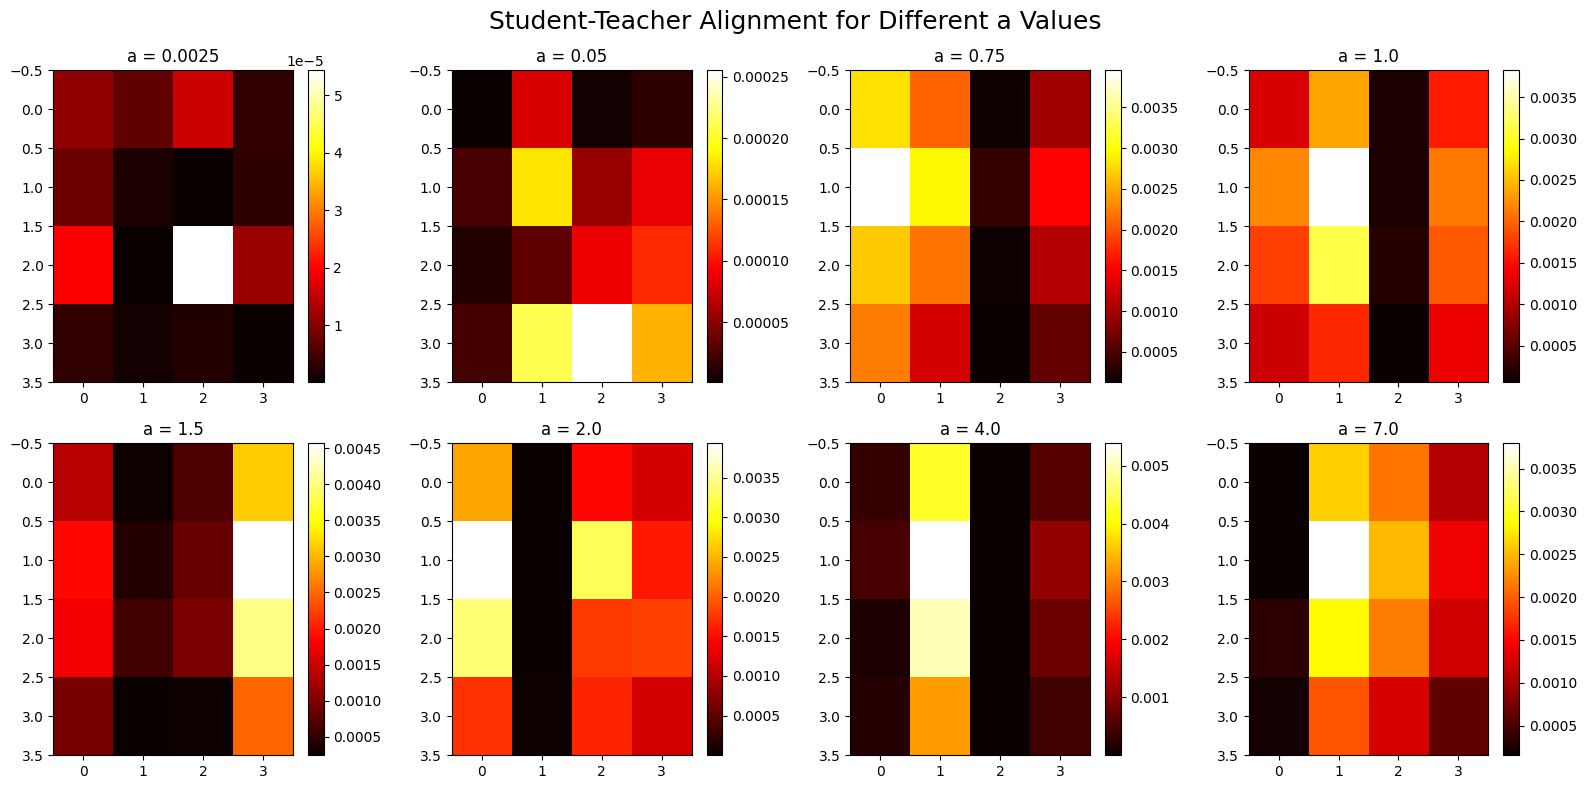

In [ ]:
# Parameters
d = 200          # Input dimension
k = 4            # The hidden units
test_ratio = 0
a_values = [0.0025, 0.05, 0.75, 1.0, 1.5, 2.0, 4.0, 7.0]
sig = lambda x: (x**2 - 1)/np.sqrt(2.0) + (x**3 - 3*x)/6

# The teacher
W_teacher = np.random.randn(d, k)
alignment_matrices = []

class StudentNet(nn.Module):
    def __init__(self, d, k):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(d, k)
        self.act = nn.Tanh()
        self.fc2 = nn.Linear(k, 1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

def train_student_and_get_alignment(a, d, k):
    n = int(a * k * d)
    X = np.random.randn(n, d)
    hidden_outputs = sig(X @ W_teacher)
    Y = np.sign(np.sum(hidden_outputs, axis=1))
    Y_bin = ((Y + 1) // 2).reshape(-1, 1)

    indices = np.random.permutation(n)
    split = int(n * (1 - test_ratio))
    X_train, X_test = X[indices[:split]], X[indices[split:]]
    Y_train, Y_test = Y_bin[indices[:split]], Y_bin[indices[split:]]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

    model = StudentNet(d, k)
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.3)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()

    W_student = model.fc1.weight.detach().numpy().T
    S = (W_teacher.T @ W_student) / d
    return S ** 2

# Run for each a
for a in a_values:
    alignment = train_student_and_get_alignment(a, d, k)
    alignment_matrices.append(alignment)

# Plot
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), tight_layout=True)
axes = axes.flatten()

for i, (Si, a) in enumerate(zip(alignment_matrices, a_values)):
    im = axes[i].imshow(Si, cmap='hot', aspect='auto')
    axes[i].set_title(f"a = {a}")
    fig.colorbar(im, ax=axes[i])

plt.suptitle("Student-Teacher Alignment for Different a Values", fontsize=18)
plt.show()